In [1]:
import torch
import pandas as pd
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
#from torchsample.callbacks import EarlyStopping
from pytorchtools import EarlyStopping
from tester import Tester

In [2]:
from models import SqueezeNet
from models import CNN_model, CNN_S
from data_preparation import load_dataset, augmentation, convert
from trainer import Trainer

In [3]:
#images, matched with labels
data = pd.read_csv('C:/Users/BOZ/Zoetis_BCS/train_test_sep/training_label.csv',index_col=False)
data_path = 'C:/Users/BOZ/Zoetis_BCS/train_test_sep/new-train/'

In [4]:
#load data/labels from image folder and excel form, as training data/labels
train_x, val_x, train_y, val_y = load_dataset(img_names=data['image_names'], data_path=data_path, labels = data['new_labels'].values)

100%|████████████████████████████████████████████████████████████████████████████████| 509/509 [00:07<00:00, 65.61it/s]


training set:  (509, 224, 224, 3) 	 trainng label:  (509,)
training set:  ((407, 224, 224, 3), (407,)) 	 testing set:  ((102, 224, 224, 3), (102,))


In [5]:
#expand the dataset by augmentation
train_x,train_y = augmentation(train_x,train_y)
#convert the data to torch tensors for training
train_x,train_y,val_x,val_y = convert(train_x,train_y,val_x,val_y)

100%|████████████████████████████████████████████████████████████████████████████████| 407/407 [00:10<00:00, 38.24it/s]


In [6]:
#training process
def train_evaluate(params,model):
    optimizer = Adam(model.parameters(), lr=params['lr'])
    criterion = CrossEntropyLoss()
    trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_x=train_x, train_y=train_y,val_x=val_x,val_y=val_y,patience=params['patience']) 
    train_losses, train_accs, validation_losses, validation_accs, predictions_test = trainer.train_val(n_epochs=params['n_epochs'],batch_size=params['batch_size'])
    return (train_losses, train_accs), (validation_losses, validation_accs), predictions_test

In [7]:
# training params
params = {
          "lr": 0.000075, 
          "batch_size": 24,
          "n_epochs": 50,
          "patience": 4
         }
# traing and evaluating  process
model1 = CNN_model(num_classes=6)
model2 = SqueezeNet(version=1.0,num_classes=6)
model3 = CNN_S(num_classes=6)
(train_losses, train_accs), (validation_losses, validation_accs), predictions = train_evaluate(params,model3) 

  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.383151).  Saving model ...
epoch: 1   training loss:  1.5089454145992502   training accuracy:  41.57379%
	 validation loss:  1.3831510543823242 	 validation accuracy:  45.09804%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (1.383151 --> 1.211481).  Saving model ...
epoch: 2   training loss:  1.2180798495517058   training accuracy:  52.72704%
	 validation loss:  1.2114812135696411 	 validation accuracy:  56.86275%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (1.211481 --> 1.150723).  Saving model ...
epoch: 3   training loss:  1.0405312103383682   training accuracy:  60.22704%
	 validation loss:  1.1507225036621094 	 validation accuracy:  63.72549%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (1.150723 --> 0.863944).  Saving model ...
epoch: 4   training loss:  0.8912822663784027   training accuracy:  65.28896%
	 validation loss:  0.8639438152313232 	 validation accuracy:  64.70588%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (0.863944 --> 0.808715).  Saving model ...
epoch: 5   training loss:  0.7842548240633572   training accuracy:  71.68989%
	 validation loss:  0.8087150454521179 	 validation accuracy:  70.58824%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
epoch: 6   training loss:  0.6659829283461851   training accuracy:  76.06553%
	 validation loss:  0.8793737888336182 	 validation accuracy:  71.56863%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (0.808715 --> 0.681212).  Saving model ...
epoch: 7   training loss:  0.5770853852524477   training accuracy:  79.93808%
	 validation loss:  0.6812120079994202 	 validation accuracy:  78.43137%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
epoch: 8   training loss:  0.5029727723668603   training accuracy:  83.16047%
	 validation loss:  0.7267723679542542 	 validation accuracy:  72.54902%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (0.681212 --> 0.564528).  Saving model ...
epoch: 9   training loss:  0.41973541773417417   training accuracy:  85.21930%
	 validation loss:  0.5645275712013245 	 validation accuracy:  83.33333%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
epoch: 10   training loss:  0.3831901072579272   training accuracy:  86.76213%
	 validation loss:  0.6033403873443604 	 validation accuracy:  83.33333%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (0.564528 --> 0.525114).  Saving model ...
epoch: 11   training loss:  0.33286659524721257   training accuracy:  88.79773%
	 validation loss:  0.5251137018203735 	 validation accuracy:  84.31373%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
epoch: 12   training loss:  0.26998586632749616   training accuracy:  90.42828%
	 validation loss:  0.7604055404663086 	 validation accuracy:  80.39216%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (0.525114 --> 0.434747).  Saving model ...
epoch: 13   training loss:  0.22024542684940732   training accuracy:  92.86636%
	 validation loss:  0.43474650382995605 	 validation accuracy:  84.31373%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
epoch: 14   training loss:  0.19647713307948672   training accuracy:  93.61455%
	 validation loss:  0.5781140923500061 	 validation accuracy:  83.33333%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 4
epoch: 15   training loss:  0.1922530348029207   training accuracy:  94.21569%
	 validation loss:  0.47710326313972473 	 validation accuracy:  84.31373%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

Validation loss decreased (0.434747 --> 0.419881).  Saving model ...
epoch: 16   training loss:  0.14182558050926994   training accuracy:  95.70949%
	 validation loss:  0.4198813736438751 	 validation accuracy:  88.23529%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
epoch: 17   training loss:  0.12322150212438668   training accuracy:  95.98039%
	 validation loss:  0.5069695115089417 	 validation accuracy:  84.31373%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 4
epoch: 18   training loss:  0.12297846638761899   training accuracy:  96.07843%
	 validation loss:  0.6207274794578552 	 validation accuracy:  85.29412%


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 4
epoch: 19   training loss:  0.09724210376906044   training accuracy:  97.19298%
	 validation loss:  0.45592573285102844 	 validation accuracy:  88.23529%


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [01:41<00:00,  1.20s/it]


EarlyStopping counter: 4 out of 4
Early stopping


In [8]:
PATH = 'C:/Users/BOZ/Zoetis_BCS/CNN_dataset/CNN_S.pt'
torch.save(model3.state_dict(), PATH)


'''
load model

model = CNN_model(nums=6)#model name
model.load_state_dict(torch.load(PATH))
model.eval()

Results = pd.DataFrame({'train_loss':train_losses, 'train_acc': train_accs, 'val_loss:': validation_losses, 'val_acc': validation_accs})
P_L = pd.DataFrame({'label': val_y, 'prediction': predictions})
Final_results = pd.concat([Results,P_L],axis=1)
Final_results.to_excel('Squeezenet_Results.xlsx')
Final_results
'''


"\nload model\n\nmodel = CNN_model(nums=6)#model name\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()\n\nResults = pd.DataFrame({'train_loss':train_losses, 'train_acc': train_accs, 'val_loss:': validation_losses, 'val_acc': validation_accs})\nP_L = pd.DataFrame({'label': val_y, 'prediction': predictions})\nFinal_results = pd.concat([Results,P_L],axis=1)\nFinal_results.to_excel('Squeezenet_Results.xlsx')\nFinal_results\n"

In [9]:
def metrics_display(epochs, train_data, validation_data):
    fig, ax = plt.subplots(1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.08))
    plt.plot(epochs, train_data, label="train")
    plt.plot(epochs, validation_data, label="valid");
    plt.scatter(epochs, train_data)
    plt.scatter(epochs, validation_data);
    plt.legend()
    plt.ylabel("acc")
    plt.xlabel("epoch")

In [10]:
def confusion_matrix_display(labels, predictions): 
    test_acc = accuracy_score(labels,predictions)
    alpha = ['2.5','2.75','3.0','3.25','3.5','4.0']
    conf_matrix = confusion_matrix(labels, predictions)
    data_conf = conf_matrix.transpose()  
    _, ax = plt.subplots()
    ax.matshow(data_conf, cmap="Blues")
    # printing exact numbers
    for (i, j), z in np.ndenumerate(data_conf):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    # axis formatting 
    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)
    plt.title("True BCS".format(" "*18), fontsize=14)
    plt.ylabel("Predicted BCS".format(" "*18), fontsize=14)

    return test_acc

0.8431372549019608


<ipython-input-10-9e82d4b99c73>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-10-9e82d4b99c73>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


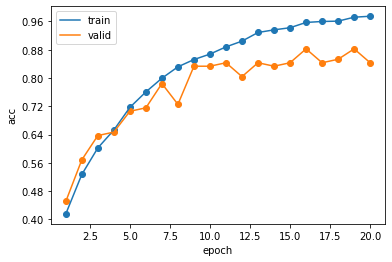

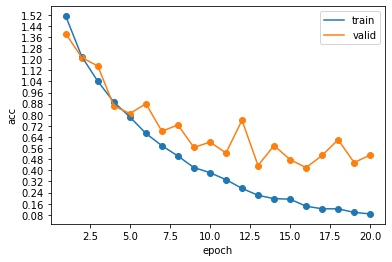

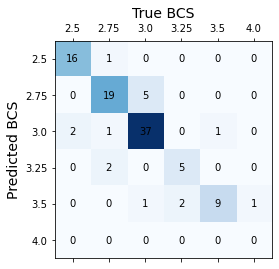

In [35]:
epochs = np.arange(1,20+1)
metrics_display(epochs, train_accs, validation_accs)
metrics_display(epochs, train_losses, validation_losses)
validation_results = confusion_matrix_display(val_y, predictions)
print(validation_results)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 68.47it/s]
<ipython-input-10-9e82d4b99c73>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-10-9e82d4b99c73>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


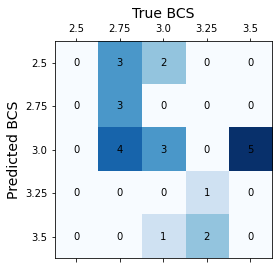

In [38]:
test_path = 'train_test_sep/new-test/'
test_label = pd.read_csv('C:/Users/BOZ/Zoetis_BCS/train_test_sep/testing_label.csv',index_col=False)
labels, predictions_test = Tester(test_path,test_label,model3)
test_acc = confusion_matrix_display(labels, predictions_test)